# STEAM RECOMMENDER SYSTEM

### Importing necessary packages

In [6]:
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 100)
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler 
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
nltk.download('punkt')
import re
import string

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Visitor\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Importing the cleaned data set

In [7]:
# importing the data set
df = pd.read_csv('steam_rs.csv')

In [8]:
# displaying 5 rows of the data frame
df.head()

,id,appid,name,purchase,hours_of_play,developer,publisher,positive,negative,release_date,english,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,detailed_description,about_the_game,short_description,price,rank
0,151603712,570,Dota 2,purchase,1.0,Valve,Valve,1096061,194043,2013-07-09,1,windows;mac;linux,0,Multi-player;Co-op;Steam Trading Cards;Steam W...,Action;Free to Play;Strategy,Free to Play;MOBA;Strategy,0,863507,142079,23944,801,100000000-200000000,<strong>The most-played game on Steam.</strong...,<strong>The most-played game on Steam.</strong...,"Every day, millions of players worldwide enter...",0.0,84.95912
1,151603712,570,Dota 2,play,0.5,Valve,Valve,1096061,194043,2013-07-09,1,windows;mac;linux,0,Multi-player;Co-op;Steam Trading Cards;Steam W...,Action;Free to Play;Strategy,Free to Play;MOBA;Strategy,0,863507,142079,23944,801,100000000-200000000,<strong>The most-played game on Steam.</strong...,<strong>The most-played game on Steam.</strong...,"Every day, millions of players worldwide enter...",0.0,84.95912
2,187131847,570,Dota 2,purchase,1.0,Valve,Valve,1096061,194043,2013-07-09,1,windows;mac;linux,0,Multi-player;Co-op;Steam Trading Cards;Steam W...,Action;Free to Play;Strategy,Free to Play;MOBA;Strategy,0,863507,142079,23944,801,100000000-200000000,<strong>The most-played game on Steam.</strong...,<strong>The most-played game on Steam.</strong...,"Every day, millions of players worldwide enter...",0.0,84.95912
3,187131847,570,Dota 2,play,2.3,Valve,Valve,1096061,194043,2013-07-09,1,windows;mac;linux,0,Multi-player;Co-op;Steam Trading Cards;Steam W...,Action;Free to Play;Strategy,Free to Play;MOBA;Strategy,0,863507,142079,23944,801,100000000-200000000,<strong>The most-played game on Steam.</strong...,<strong>The most-played game on Steam.</strong...,"Every day, millions of players worldwide enter...",0.0,84.95912
4,176410694,570,Dota 2,purchase,1.0,Valve,Valve,1096061,194043,2013-07-09,1,windows;mac;linux,0,Multi-player;Co-op;Steam Trading Cards;Steam W...,Action;Free to Play;Strategy,Free to Play;MOBA;Strategy,0,863507,142079,23944,801,100000000-200000000,<strong>The most-played game on Steam.</strong...,<strong>The most-played game on Steam.</strong...,"Every day, millions of players worldwide enter...",0.0,84.95912


In [21]:
# getting name count
df_name_count = pd.DataFrame(df.groupby('name').size().sort_values(), columns=['count'])
df_name_count

,count
name,
Magnifico,1
Psichodelya,1
Wooden Floor,1
Time Ramesside (A New Reckoning),1
Break the Cube,1
...,...
Counter-Strike,1424
Left 4 Dead 2,1752
Unturned,2632


In [26]:
df.groupby(['name'])['rank'].mean().reset_index()

,name,rank
0,0RBITALIS,71.785714
1,10 Second Ninja,85.897436
2,"10,000,000",89.683774
3,100% Orange Juice,93.100992
4,1000 Amps,78.877888
...,...,...
2293,rFactor 2,86.909956
2294,resident evil 4 / biohazard 4,86.941143
2295,rymdkapsel,82.568807
2296,samurai_jazz,68.181818


Text(0.5, 1.0, 'Average Price of Games')

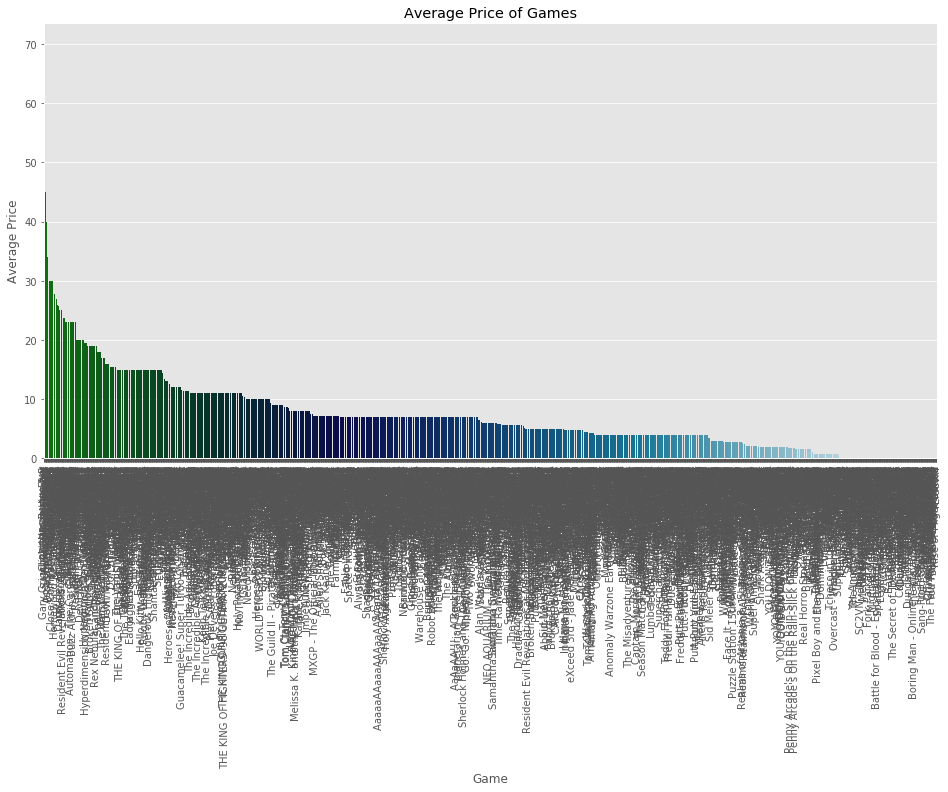

In [37]:
# graphing the average prices of games
game_list=list(df.name.unique())
average_price=[]

for i in game_list:
    x=df[df.name==i]
    game_average=sum(x.price)/len(x)
    average_price.append(game_average)

df1=pd.DataFrame({'game_list':game_list,'average_price':average_price})
new_index=df1.average_price.sort_values(ascending=False).index.values
sorted_data=df1.reindex(new_index)

plt.figure(figsize=(16,8))
ax=sns.barplot(x=sorted_data.game_list,y=sorted_data.average_price,palette='ocean')

plt.xticks(rotation=90)
plt.xlabel('Game')
plt.ylabel('Average Price')
plt.title('Average Price of Games')

# Content based model

Content based recommender systems predict what the user likes based on what they have liked in the past. This creates personlizes recommendations for the user based on interests, and other such factors. To recommend a user similar items that the user has previously liked, TFIDF can be used, as it helps identify which item is similar to each other. Each of these items are represented using TFIDF vectors.
<br><br>
TFIDF is a very crucial in building the recommender system. Term frequency (TF) is the frequencies of a specific word in a document, and inverse document frequency (IDF) is the universe of document frequencies throughout the entire corpus of documents.

In [65]:
# displaying the data frame
df.head()

,id,appid,name,purchase,hours_of_play,developer,publisher,positive,negative,release_date,english,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,detailed_description,about_the_game,short_description,price,rank
0,151603712,570,Dota 2,purchase,1.0,Valve,Valve,1096061,194043,2013-07-09,1,windows;mac;linux,0,Multi-player;Co-op;Steam Trading Cards;Steam W...,Action;Free to Play;Strategy,Free to Play;MOBA;Strategy,0,863507,142079,23944,801,100000000-200000000,<strong>The most-played game on Steam.</strong...,<strong>The most-played game on Steam.</strong...,"Every day, millions of players worldwide enter...",0.0,84.95912
1,151603712,570,Dota 2,play,0.5,Valve,Valve,1096061,194043,2013-07-09,1,windows;mac;linux,0,Multi-player;Co-op;Steam Trading Cards;Steam W...,Action;Free to Play;Strategy,Free to Play;MOBA;Strategy,0,863507,142079,23944,801,100000000-200000000,<strong>The most-played game on Steam.</strong...,<strong>The most-played game on Steam.</strong...,"Every day, millions of players worldwide enter...",0.0,84.95912
2,187131847,570,Dota 2,purchase,1.0,Valve,Valve,1096061,194043,2013-07-09,1,windows;mac;linux,0,Multi-player;Co-op;Steam Trading Cards;Steam W...,Action;Free to Play;Strategy,Free to Play;MOBA;Strategy,0,863507,142079,23944,801,100000000-200000000,<strong>The most-played game on Steam.</strong...,<strong>The most-played game on Steam.</strong...,"Every day, millions of players worldwide enter...",0.0,84.95912
3,187131847,570,Dota 2,play,2.3,Valve,Valve,1096061,194043,2013-07-09,1,windows;mac;linux,0,Multi-player;Co-op;Steam Trading Cards;Steam W...,Action;Free to Play;Strategy,Free to Play;MOBA;Strategy,0,863507,142079,23944,801,100000000-200000000,<strong>The most-played game on Steam.</strong...,<strong>The most-played game on Steam.</strong...,"Every day, millions of players worldwide enter...",0.0,84.95912
4,176410694,570,Dota 2,purchase,1.0,Valve,Valve,1096061,194043,2013-07-09,1,windows;mac;linux,0,Multi-player;Co-op;Steam Trading Cards;Steam W...,Action;Free to Play;Strategy,Free to Play;MOBA;Strategy,0,863507,142079,23944,801,100000000-200000000,<strong>The most-played game on Steam.</strong...,<strong>The most-played game on Steam.</strong...,"Every day, millions of players worldwide enter...",0.0,84.95912


In [66]:
tags = {}
for col in ['developer', 'steamspy_tags']:
    for id in df['id'].unique():
        for i in df[df['id'] == id][col]:
            if id in tags:
                tags[id].append(' '.join(i.lower().split('|')))
            else:
                tags[id] = i.lower().split('|')

In [67]:
tags_list = list(tags.values())

In [68]:
tags_list

[['valve',
  'valve',
  'valve',
  'valve',
  'valve',
  'valve',
  'facepunch studios',
  'facepunch studios',
  'grinding gear games',
  'grinding gear games',
  'freejam',
  'freejam',
  'crystal dynamics, eidos-montréal, feral interactive (mac), feral interactive (linux)',
  'crystal dynamics, eidos-montréal, feral interactive (mac), feral interactive (linux)',
  'valve',
  'valve',
  'bethesda game studios',
  'bethesda game studios',
  'irrational games, virtual programming (linux)',
  'irrational games, virtual programming (linux)',
  'wild shadow studios, deca games',
  'wild shadow studios, deca games',
  'remedy entertainment',
  'huniepot',
  'huniepot',
  'dry cactus',
  'dry cactus',
  'stoic',
  'stoic',
  'hunted cow studios',
  'hunted cow studios',
  'free to play;moba;strategy',
  'free to play;moba;strategy',
  'free to play;multiplayer;fps',
  'free to play;multiplayer;fps',
  'zombies;co-op;fps',
  'zombies;co-op;fps',
  'sandbox;multiplayer;funny',
  'sandbox;mult

In [69]:
stopwords_list = stopwords.words('english')

In [70]:
stopwords_list += list(string.punctuation)

In [71]:
def process_article(article):
    
    article = ' '.join(article)
    
    tokens = word_tokenize(article) 
    #   word_tokenize splits text into a list of strings split based on white 
    #   space (or aposraphes)

    tokens_2 = [] 
    # empty list to store only relevant (lowercased) tokens that aren't in the 
    #   stopword list
    
    for token in tokens:
    
        if token.lower() not in stopwords_list:
                
            tokens_2.append(token.lower())
                
    return tokens_2

In [72]:
processed_data = list(map(process_article, tags_list))

In [73]:
len(processed_data)

10385

In [74]:
total_vocab = set()
for doc in processed_data:
    total_vocab.update(doc)

In [75]:
len(total_vocab)

2519

In [76]:
articles_concat = []
for doc in processed_data:
    articles_concat += doc

In [77]:
freqdist = FreqDist(articles_concat)

In [78]:
most_common = freqdist.most_common(20)
most_common

[('free', 37226),
 ('play', 37000),
 ('action', 27316),
 ('valve', 24321),
 ('multiplayer', 23304),
 ('fps', 21279),
 ('strategy', 21005),
 ('games', 17030),
 ('indie', 12723),
 ('world', 11202),
 ('co-op', 10414),
 ('moba', 10267),
 ('studios', 9968),
 ('rpg', 8839),
 ('zombies', 7938),
 ('survival', 7864),
 ('open', 7473),
 ('adventure', 6833),
 ('simulation', 5880),
 ('puzzle', 5287)]

<BarContainer object of 20 artists>

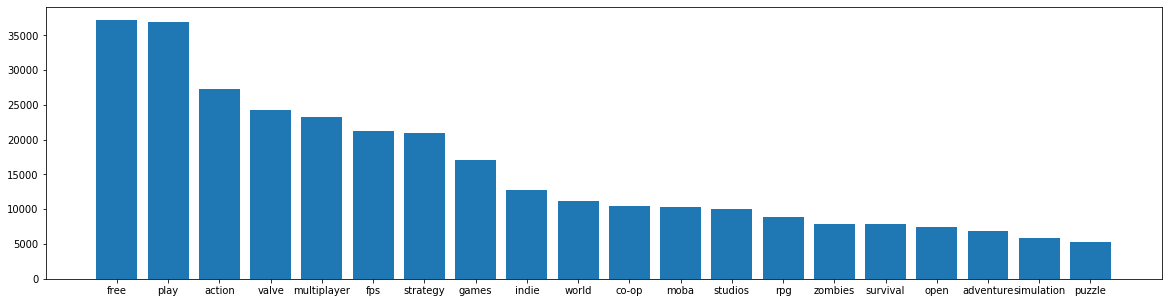

In [79]:
plt.figure(figsize = (20, 5))
plt.bar([word[0] for word in most_common], [word[1] for word in most_common])

In [80]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [81]:
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), stop_words=stopwords_list)

In [82]:
tags_list_2 = [' '.join(x) for x in tags_list]

In [83]:
tfidf_matrix = tfidf.fit_transform(tags_list_2)

In [84]:
tfidf_matrix.shape

(10385, 23835)

### Calculating cosine similarities

In [85]:
from sklearn.metrics.pairwise import linear_kernel

In [86]:
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

### Making recommendations

In [87]:
# creating a Series for the movie titles so they are associated to an ordered numerical
# list I will use later to match the indexes
indices = pd.Series(df.name)
indices

0                                Dota 2
1                                Dota 2
2                                Dota 2
3                                Dota 2
4                                Dota 2
                      ...              
99893    YOU DON'T KNOW JACK TELEVISION
99894    YOU DON'T KNOW JACK TELEVISION
99895    YOU DON'T KNOW JACK TELEVISION
99896    YOU DON'T KNOW JACK TELEVISION
99897    YOU DON'T KNOW JACK TELEVISION
Name: name, Length: 99898, dtype: object

In [88]:
#  defining the function that takes in game title 
# as input and returns the top 10 recommended games
def recommendations(title, cosine_similarities = cosine_similarities):
    
    # initializing the empty list of recommended movies
    recommended_games = []
    
    # gettin the index of the game that matches the title
    idx = indices[indices == title].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_similarities[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar games
    top_10_indexes = list(score_series.iloc[1:11].index)
    
    # populating the list with the titles of the best 10 matching games
    for i in top_10_indexes:
        recommended_games.append(list(df.name)[i])
        
    return recommended_games

In [89]:
content_mod = recommendations('Dota 2')

### Evaluation

<b> MAE & RMSE

In [100]:
df.columns

Index(['id', 'appid', 'name', 'purchase', 'hours_of_play', 'developer', 'publisher', 'positive',
       'negative', 'release_date', 'english', 'platforms', 'required_age', 'categories', 'genres',
       'steamspy_tags', 'achievements', 'positive_ratings', 'negative_ratings', 'average_playtime',
       'median_playtime', 'owners', 'detailed_description', 'about_the_game', 'short_description',
       'price', 'rank'],
      dtype='object')

In [101]:
df2 = df[['id', 'appid', 'rank', 'price']]

In [110]:
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split

In [112]:
algo = TruncatedSVD(random_state=0)

In [113]:
algo.fit(trainSet)

TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5, random_state=0,
             tol=0.0)

In [119]:
predictions = algo.test(testSet)

def MAE(predictions):
        return accuracy.mae(predictions, verbose=False)
def RMSE(predictions):
        return accuracy.rmse(predictions, verbose=False)
    
print("RMSE: ", RMSE(predictions))
print("MAE: ", MAE(predictions))

AttributeError: 'TruncatedSVD' object has no attribute 'test'